# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [49]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, desc, col, avg, count, date_format
from pyspark.sql.types import IntegerType, DateType, DoubleType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as F
import datetime
import matplotlib.pyplot as plt
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler,MinMaxScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline


In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Churn Model - Udacity") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
data = 'mini_sparkify_event_data.json'

df = spark.read.json(data)

df.count()

286500

In [4]:
# What fields are we working with?
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Put a method here that determines if there is missing data.

In [6]:
# How many missing values do we have?
missing_value_counter = df.dropna(how = "any")

missing_value_counter.count()

# So we have 286500 - 228108 missing values.

228108

In [7]:
# How many missing value in userId or sessionId
missing_value_counter = df.dropna(how = "any", subset = ['userId','sessionId'])

missing_value_counter.count()

# No missing values when only looking at userId and sessionId.

286500

In [8]:
# Are there any empty string values in the dataset?

empty_value_counter = df.filter(df.userId == '')

empty_value_counter.count()

8346

In [9]:
# Are there any empty string values in the dataset for sessionId?
empty_value_counter = df.filter(df.sessionId == '')

empty_value_counter.count()

0

In [10]:
# Remove the 8346 entries with no userId

df = df.filter(df.userId != '')

In [11]:
# Verify removal of null values worked.
empty_value_counter = df.filter(df.userId == '')

# Looks like everything worked as expected.
empty_value_counter.count()

0

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# Preliminary Analysis

# Lets look at all possible values for column: Page
df.select('Page').distinct().collect()

[Row(Page='Cancel'),
 Row(Page='Submit Downgrade'),
 Row(Page='Thumbs Down'),
 Row(Page='Home'),
 Row(Page='Downgrade'),
 Row(Page='Roll Advert'),
 Row(Page='Logout'),
 Row(Page='Save Settings'),
 Row(Page='Cancellation Confirmation'),
 Row(Page='About'),
 Row(Page='Settings'),
 Row(Page='Add to Playlist'),
 Row(Page='Add Friend'),
 Row(Page='NextSong'),
 Row(Page='Thumbs Up'),
 Row(Page='Help'),
 Row(Page='Upgrade'),
 Row(Page='Error'),
 Row(Page='Submit Upgrade')]

In [13]:
# Our definition of churn will be when the user finalizes their cancelation.
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churned", flag_cancellation_event("page"))

# Distinguish data as pre or post cancellation
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("phase", Fsum("churned").over(windowval))


In [14]:
# How many users actually churned?
churn_counter = df.filter(df.churned == 1)

# Looks like only 52 users churned
churn_counter.count()

52

In [15]:
# Can we gain anything by looking at the gender of those 52 users who churned?
gender_churn_count = df.groupBy('gender', 'churned').count()

gender_churn_count.show()

+------+-------+------+
|gender|churned| count|
+------+-------+------+
|     M|      1|    32|
|     F|      0|154558|
|     F|      1|    20|
|     M|      0|123544|
+------+-------+------+



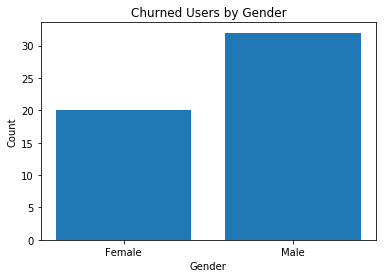

In [16]:
# Filter the DataFrame to get only the churned users
churned_users = gender_churn_count.filter(gender_churn_count['churned'] == '1')

# Extract the counts for male and female churned users
male_churn_count = churned_users.filter(churned_users['gender'] == 'M').select('count').collect()[0][0]
female_churn_count = churned_users.filter(churned_users['gender'] == 'F').select('count').collect()[0][0]

# Create a bar plot
plt.bar(['Male', 'Female'], [male_churn_count, female_churn_count])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Churned Users by Gender')
plt.show()

In [17]:
# Create some UDF functions for later use. 
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
song=udf(lambda x : int(x=='NextSong'), IntegerType())

In [18]:
# Lets look at songs per day.
df = df.withColumn('date', get_day(col('ts')))
df.filter(col('phase')==1).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()
df.filter(col('phase')==0).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8112072039942939|
+------------------+

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8217840456084702|
+------------------+



+----+-----+
|hour|count|
+----+-----+
|   0|    3|
|   1|    1|
|   2|    1|
|   3|    2|
|   4|    2|
|   5|    1|
|   7|    6|
|   8|    1|
|  10|    1|
|  11|    2|
|  12|    2|
|  13|    1|
|  14|    1|
|  15|    4|
|  16|    4|
|  17|    2|
|  18|    3|
|  19|    5|
|  20|    3|
|  21|    3|
+----+-----+
only showing top 20 rows



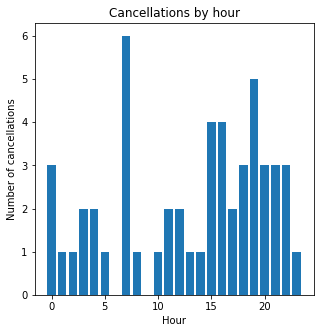

In [19]:
# Lets look at cancellations per hour
df = df.withColumn("hour", get_hour(df.ts))
cancels_per_hour = df.filter(df.page == "Cancellation Confirmation").groupby(df.hour).count().orderBy(df.hour.cast("float"))
cancels_per_hour.show()

# grab hours and counts
hours = [row['hour'] for row in cancels_per_hour.collect()]
hours = [int(x) for x in hours]
counts = [row['count'] for row in cancels_per_hour.collect()]
counts = [int(x) for x in counts]

# Create a bar plot
plt.figure(figsize=(5, 5))
plt.bar(hours, counts)
plt.xlabel('Hour')
plt.ylabel('Number of cancellations')
plt.title('Cancellations by hour')
plt.show()

In [20]:
# Lets look at distribution of paid and free users who churned
print(df.filter((df.page == 'Cancellation Confirmation') & (df.level == 'paid')).count())

print(df.filter((df.page == 'Cancellation Confirmation') & (df.level == 'free')).count())

31
21


In [21]:
# Group by 'date', 'churn', and 'page' columns and calculate the count of 'page'
songs_played_per_day = df.filter(df['page'] == 'NextSong').groupBy('date', 'churned').count()

# Display the result
songs_played_per_day.show()

+----------+-------+-----+
|      date|churned|count|
+----------+-------+-----+
|2018-10-01|      0| 3358|
|2018-10-22|      0| 3987|
|2018-10-04|      0| 3706|
|2018-10-29|      0| 4796|
|2018-10-15|      0| 4198|
|2018-11-11|      0| 2284|
|2018-10-02|      0| 3526|
|2018-12-03|      0|    1|
|2018-10-13|      0| 2423|
|2018-11-19|      0| 3835|
|2018-11-24|      0| 2113|
|2018-10-30|      0| 5405|
|2018-10-11|      0| 4565|
|2018-10-10|      0| 5101|
|2018-10-14|      0| 2130|
|2018-10-27|      0| 2909|
|2018-11-21|      0| 5198|
|2018-10-21|      0| 2553|
|2018-10-26|      0| 3495|
|2018-11-22|      0| 2590|
+----------+-------+-----+
only showing top 20 rows



In [22]:
# How many songs played per day?

# Group by 'date', 'churn', and 'page' columns and calculate the count of 'page'
songs_played_per_day = df.filter((df['page'] == 'NextSong') & (df['phase'] == '1')).groupBy('date', 'churned').count()

# Display the result
songs_played_per_day.show()

+----------+-------+-----+
|      date|churned|count|
+----------+-------+-----+
|2018-10-01|      0|  870|
|2018-10-22|      0|  559|
|2018-10-04|      0| 1157|
|2018-10-29|      0|  747|
|2018-10-15|      0| 1444|
|2018-11-11|      0|  352|
|2018-10-02|      0| 1431|
|2018-10-13|      0|  981|
|2018-11-19|      0|   86|
|2018-11-24|      0|   99|
|2018-10-30|      0| 1046|
|2018-10-11|      0| 2047|
|2018-10-10|      0| 1397|
|2018-10-14|      0|  481|
|2018-10-27|      0|  265|
|2018-10-21|      0|  317|
|2018-10-26|      0|  833|
|2018-10-25|      0|  558|
|2018-10-18|      0| 1060|
|2018-11-15|      0|  349|
+----------+-------+-----+
only showing top 20 rows



In [23]:
# How many times did users who churned visit the help page
churned_help_count = df.filter((df['page'] == 'Help') & (df['phase'] == '1')).count()

# So the 52 churnes users visited the help page 239 times.
churned_help_count

239

In [24]:
# How many users actually churned?
Non_churned_help_counter = df.filter((df.phase == 0) & (df['page'] == 'Help')).count()

# Compared to 1215 help page visits by non-churned users.
Non_churned_help_counter

1215

In [25]:
# How many times did churned users see and advertisement. 
churned_ad_count = df.filter((df['page'] == 'Roll Advert') & (df['phase'] == '1')).count()

# So the 52 churnes users saw 967 ads.
churned_ad_count

967

In [26]:
# How many times did churned users see and advertisement. 
non_churned_ad_count = df.filter((df['page'] == 'Roll Advert') & (df['phase'] == '0')).count()

# Compared to 2966 ads seen by the non-churned users.
non_churned_ad_count

2966

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [27]:
thumbs_up_per_day = df.filter(df.page == "Thumbs Up")\
.select('userId','page','ts')\
.withColumn('date',get_day(col('ts')))\
.groupBy('userId','date').agg(count(col("page")))\
.groupBy('userId').agg(avg(col('count(page)')))\
.withColumnRenamed('avg(count(page))', 'Thumbs Up Per Day')

print(thumbs_up_per_day.show())

+------+------------------+
|userId| Thumbs Up Per Day|
+------+------------------+
|200002|               3.0|
|100010|2.8333333333333335|
|    51| 8.333333333333334|
|   124| 5.896551724137931|
|     7|              1.75|
|    15|               5.4|
|    54| 6.037037037037037|
|   155| 8.285714285714286|
|   132| 5.333333333333333|
|100014|               3.4|
|   154|3.6666666666666665|
|    11| 2.857142857142857|
|   101| 7.818181818181818|
|300017| 7.046511627906977|
|   138|            5.9375|
|    29|              6.16|
|    69|               6.0|
|100021|              2.75|
|    42| 4.256410256410256|
|   112|               1.5|
+------+------------------+
only showing top 20 rows

None


In [28]:
thumbs_down_per_day = df.filter(df.page == "Thumbs Down")\
.select('userId','page','ts')\
.withColumn('date',get_day(col('ts')))\
.groupBy('userId','date').agg(count(col("page")))\
.groupBy('userId').agg(avg(col('count(page)')))\
.withColumnRenamed('avg(count(page))', 'Thumbs Down Per Day')

print(thumbs_down_per_day.show())

+------+-------------------+
|userId|Thumbs Down Per Day|
+------+-------------------+
|100010|               1.25|
|200002|                3.0|
|   124| 1.8636363636363635|
|    51|                2.1|
|     7|                1.0|
|    15|                1.4|
|    54| 1.5263157894736843|
|   155|                1.0|
|   132|                1.7|
|100014|                1.0|
|    11| 1.2857142857142858|
|   101| 2.2857142857142856|
|300017| 1.6470588235294117|
|   138| 2.6666666666666665|
|    29| 1.4666666666666666|
|    69|                1.5|
|100021| 1.6666666666666667|
|    42| 1.1904761904761905|
|   112|                1.5|
|    87|                1.0|
+------+-------------------+
only showing top 20 rows

None


In [29]:
errors_per_day = df.filter(df.page == "Error")\
.select('userId','page','ts')\
.withColumn('date',get_day(col('ts')))\
.groupBy('userId','date').agg(count(col("page")))\
.groupBy('userId').agg(avg(col('count(page)')))\
.withColumnRenamed('avg(count(page))', 'Errors Per Day')

print(errors_per_day.show())

+------+------------------+
|userId|    Errors Per Day|
+------+------------------+
|   124|               1.2|
|     7|               1.0|
|    51|               1.0|
|    15|               1.0|
|    54|               1.0|
|   155|               1.0|
|   132|               1.0|
|   101|               1.5|
|    11|               1.0|
|300017|              1.25|
|   138|               1.0|
|    69|1.3333333333333333|
|100021|               1.0|
|    42|               1.0|
|    73|               1.0|
|200010|               1.0|
|   113|               1.0|
|    30|               1.0|
|    59|               2.0|
|   139|               1.0|
+------+------------------+
only showing top 20 rows

None


In [30]:
help_visits_per_day = df.filter(df.page == "Help")\
.select('userId','page','ts')\
.withColumn('date',get_day(col('ts')))\
.groupBy('userId','date').agg(count(col("page")))\
.groupBy('userId').agg(avg(col('count(page)')))\
.withColumnRenamed('avg(count(page))', 'Help Visits Per Day')

print(help_visits_per_day.show())

+------+-------------------+
|userId|Help Visits Per Day|
+------+-------------------+
|100010|                1.0|
|200002|                1.0|
|   124|             1.4375|
|     7|                1.0|
|    51| 1.7142857142857142|
|    54| 1.1333333333333333|
|    15| 1.1428571428571428|
|   155|                1.8|
|   132| 1.7777777777777777|
|100014|                1.0|
|   154|                1.0|
|   101| 1.7142857142857142|
|    11|                1.5|
|300017|               1.35|
|   138| 1.8571428571428572|
|    29| 1.5555555555555556|
|    69| 2.3333333333333335|
|    42| 1.1764705882352942|
|   112|                1.0|
|    87|                1.6|
+------+-------------------+
only showing top 20 rows

None


In [31]:
number_of_friends = df.filter(df.page == "Add Friend")\
.select('userId','page')\
.groupBy('userId')\
.agg(count(col('page')))\
.withColumnRenamed('count(page)', 'Number Of Friends')

print(number_of_friends.show())

+------+-----------------+
|userId|Number Of Friends|
+------+-----------------+
|100010|                4|
|200002|                4|
|    51|               28|
|   124|               74|
|     7|                1|
|    54|               33|
|    15|               31|
|   155|               11|
|   132|               41|
|   154|                3|
|100014|                6|
|   101|               29|
|    11|                6|
|   138|               41|
|300017|               63|
|    29|               47|
|    69|               12|
|100021|                7|
|    42|               52|
|   112|                7|
+------+-----------------+
only showing top 20 rows

None


In [32]:
free_users = udf(lambda x: 1 if x == "free" else 0, IntegerType())
paid_users = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
visit_home = udf(lambda x: 1 if x == "Home" else 0, IntegerType())
error_occured = udf(lambda x: 1 if x == "Error" else 0, IntegerType())
help_needed = udf(lambda x: 1 if x == "Help" else 0, IntegerType())

In [33]:
user_level = df.select('userId','level')\
.drop_duplicates()\
.withColumn('free user', free_users('level'))\
.withColumn('paid user', paid_users('level'))\
.drop('level')

user_level.show()

+------+---------+---------+
|userId|free user|paid user|
+------+---------+---------+
|100021|        1|        0|
|200021|        1|        0|
|200001|        1|        0|
|     6|        1|        0|
|300022|        0|        1|
|   132|        1|        0|
|   112|        1|        0|
|    79|        1|        0|
|200008|        1|        0|
|    16|        0|        1|
|200007|        0|        1|
|300015|        1|        0|
|    39|        1|        0|
|300014|        0|        1|
|    61|        1|        0|
|    56|        0|        1|
|300014|        1|        0|
|   100|        0|        1|
|300024|        0|        1|
|300023|        0|        1|
+------+---------+---------+
only showing top 20 rows



In [34]:
# Average number of songs before user visits home

play_sum = df.filter((df.page == 'Home') | (df.page == 'NextSong'))\
.select('userId','page','ts')\
.withColumn("visited home", visit_home(col('page')))\
.withColumn("play period", Fsum("visited home").over(windowval))

avg_song_until_home = play_sum.filter((play_sum.page == 'NextSong'))\
.groupBy('userID', 'play period')\
.agg(count(col('play period')))\
.groupBy('userID')\
.agg(avg(col('count(play period)')))\
.withColumnRenamed('avg(count(play period))', 'Avg Songs Played Before Home')


avg_song_until_home.show()

+------+----------------------------+
|userID|Avg Songs Played Before Home|
+------+----------------------------+
|100010|          22.916666666666668|
|200002|                       19.35|
|   125|                         8.0|
|   124|            24.4251497005988|
|    51|          29.319444444444443|
|     7|          13.636363636363637|
|    15|          21.266666666666666|
|    54|           24.92105263157895|
|   155|          29.285714285714285|
|100014|                      32.125|
|   132|           24.71794871794872|
|   154|                        14.0|
|   101|          24.958333333333332|
|    11|          17.486486486486488|
|   138|          30.895522388059703|
|300017|           24.54054054054054|
|100021|                      14.375|
|    29|          25.233333333333334|
|    69|                     23.4375|
|   112|           16.53846153846154|
+------+----------------------------+
only showing top 20 rows



In [35]:
# How many songs on average before error

error_sum = df.filter((df.page == 'Error') | (df.page == 'NextSong'))\
.select('userId','page','ts')\
.withColumn("error experienced", error_occured(col('page')))\
.withColumn("play period", Fsum("error experienced").over(windowval))

avg_song_until_error = error_sum.filter(error_sum.page == 'NextSong')\
.groupBy('userID', 'play period')\
.agg(count(col('play period')))\
.groupBy('userID')\
.agg(avg(col('count(play period)')))\
.withColumnRenamed('avg(count(play period))', 'Avg Songs Played Before Error')

avg_song_until_error.show()

+------+-----------------------------+
|userID|Avg Songs Played Before Error|
+------+-----------------------------+
|100010|                        275.0|
|200002|                        387.0|
|   125|                          8.0|
|   124|            582.7142857142857|
|    51|                       1055.5|
|     7|                         75.0|
|    15|                        638.0|
|    54|                       1420.5|
|   155|                        205.0|
|100014|                        257.0|
|   132|                        482.0|
|   154|                         84.0|
|   101|                       449.25|
|    11|                        323.5|
|   138|                       1035.0|
|300017|            605.3333333333334|
|100021|            76.66666666666667|
|    29|                       3028.0|
|    69|                        225.0|
|   112|                        215.0|
+------+-----------------------------+
only showing top 20 rows



In [36]:
# How many songs on average before help

help_sum = df.filter((df.page == 'Help') | (df.page == 'NextSong'))\
.select('userId','page','ts')\
.withColumn("help needed", help_needed(col('page')))\
.withColumn("play period", Fsum("help needed").over(windowval))

avg_song_until_help = help_sum.filter(help_sum.page == 'NextSong')\
.groupBy('userID', 'play period')\
.agg(count(col('play period')))\
.groupBy('userID')\
.agg(avg(col('count(play period)')))\
.withColumnRenamed('avg(count(play period))', 'Avg Songs Played Before Help Needed')

avg_song_until_help.show()

+------+-----------------------------------+
|userID|Avg Songs Played Before Help Needed|
+------+-----------------------------------+
|100010|                  91.66666666666667|
|200002|                              129.0|
|   125|                                8.0|
|   124|                 169.95833333333334|
|    51|                  162.3846153846154|
|     7|                               75.0|
|    15|                 212.66666666666666|
|    54|                 157.83333333333334|
|   155|                               82.0|
|100014|                  85.66666666666667|
|   132|                 113.41176470588235|
|   154|                               42.0|
|   101|                             149.75|
|    11|                             161.75|
|   138|                 159.23076923076923|
|300017|                 129.71428571428572|
|100021|                              230.0|
|    29|                 104.41379310344827|
|    69|                 160.71428571428572|
|   112|  

In [37]:
def generate_features(df):
    '''
    This method will handle the entire generation of the data set we 
    will use to feed our machine learning model. 
    
    Parameters: 
        df : The inital dataset read in from 'mini_sparkify_event_data.json'
    
    Output: 
        df with the following fields:
            - Average thumbs up per day
            - Average thumbs down per day
            - Average errors experienced per day
            - Average help requests per day
            - Whether the user has a paid account or free account
            - How many friends the account has
            - The average number of songs played before visiting home page.
            - The average number of songs played before needing to visit help page.
            - The average number of songs played before experiencing an error.
    '''
    
    users = df.filter((df.userId != '')).select('userId').drop_duplicates()
    
    # Define Churn
    flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    churned = df.withColumn("churned", flag_cancellation_event("page"))\
    .select(['userId', 'churned'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(churned)','churned')
    
    # Declare helper udf functions
    free_users = udf(lambda x: 1 if x == "free" else 0, IntegerType())
    paid_users = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
    visit_home = udf(lambda x: 1 if x == "Home" else 0, IntegerType())
    error_occured = udf(lambda x: 1 if x == "Error" else 0, IntegerType())
    help_needed = udf(lambda x: 1 if x == "Help" else 0, IntegerType())
    
    # Calculate average thumbs up per day.
    thumbs_up_per_day = df.filter(df.page == "Thumbs Up")\
    .select('userId','page','ts')\
    .withColumn('date',get_day(col('ts')))\
    .groupBy('userId','date').agg(count(col("page")))\
    .groupBy('userId').agg(avg(col('count(page)')))\
    .withColumnRenamed('avg(count(page))', 'Thumbs Up Per Day')
    
    # Find average thumbs down per day
    thumbs_down_per_day = df.filter(df.page == "Thumbs Down")\
    .select('userId','page','ts')\
    .withColumn('date',get_day(col('ts')))\
    .groupBy('userId','date').agg(count(col("page")))\
    .groupBy('userId').agg(avg(col('count(page)')))\
    .withColumnRenamed('avg(count(page))', 'Thumbs Down Per Day')
    
    # Find average errors experienced per day
    errors_per_day = df.filter(df.page == "Error")\
    .select('userId','page','ts')\
    .withColumn('date',get_day(col('ts')))\
    .groupBy('userId','date').agg(count(col("page")))\
    .groupBy('userId').agg(avg(col('count(page)')))\
    .withColumnRenamed('avg(count(page))', 'Errors Per Day')
    
    # Find average help visits per day
    help_visits_per_day = df.filter(df.page == "Help")\
    .select('userId','page','ts')\
    .withColumn('date',get_day(col('ts')))\
    .groupBy('userId','date').agg(count(col("page")))\
    .groupBy('userId').agg(avg(col('count(page)')))\
    .withColumnRenamed('avg(count(page))', 'Help Visits Per Day')
    
    # Find number of friends each user has
    number_of_friends = df.filter(df.page == "Add Friend")\
    .select('userId','page')\
    .groupBy('userId')\
    .agg(count(col('page')))\
    .withColumnRenamed('count(page)', 'Number Of Friends')
    
    # Find the level (free vs paid) for each user
    user_level = df.select('userId','level')\
    .drop_duplicates()\
    .withColumn('free user', free_users('level'))\
    .withColumn('paid user', paid_users('level'))\
    .drop('level')
    
    # Average number of songs played before user vistis home screen
    
    play_sum = df.filter((df.page == 'Home') | (df.page == 'NextSong'))\
    .select('userId','page','ts')\
    .withColumn("visited home", visit_home(col('page')))\
    .withColumn("play period", Fsum("visited home").over(windowval))

    avg_song_until_home = play_sum.filter((play_sum.page == 'NextSong'))\
    .groupBy('userID', 'play period')\
    .agg(count(col('play period')))\
    .groupBy('userID')\
    .agg(avg(col('count(play period)')))\
    .withColumnRenamed('avg(count(play period))', 'Avg Songs Played Before Home')

    # Average number of songs played before user needs to visit help page
    help_sum = df.filter((df.page == 'Help') | (df.page == 'NextSong'))\
    .select('userId','page','ts')\
    .withColumn("help needed", help_needed(col('page')))\
    .withColumn("play period", Fsum("help needed").over(windowval))

    avg_song_until_help = help_sum.filter(help_sum.page == 'NextSong')\
    .groupBy('userID', 'play period')\
    .agg(count(col('play period')))\
    .groupBy('userID')\
    .agg(avg(col('count(play period)')))\
    .withColumnRenamed('avg(count(play period))', 'Avg Songs Played Before Help Needed')
    
    # Average number of songs played before user experiences an error
    error_sum = df.filter((df.page == 'Error') | (df.page == 'NextSong'))\
    .select('userId','page','ts')\
    .withColumn("error experienced", error_occured(col('page')))\
    .withColumn("play period", Fsum("error experienced").over(windowval))

    avg_song_until_error = error_sum.filter(error_sum.page == 'NextSong')\
    .groupBy('userID', 'play period')\
    .agg(count(col('play period')))\
    .groupBy('userID')\
    .agg(avg(col('count(play period)')))\
    .withColumnRenamed('avg(count(play period))', 'Avg Songs Played Before Error')
    
    df = users.join(avg_song_until_error, on='userId')\
    .join(thumbs_up_per_day, on='userId')\
    .join(thumbs_down_per_day, on='userId')\
    .join(errors_per_day, on='userId')\
    .join(help_visits_per_day, on='userId')\
    .join(number_of_friends, on='userId')\
    .join(user_level, on='userId')\
    .join(avg_song_until_home, on='userId')\
    .join(avg_song_until_help, on='userId')\
    .join(churned, on='userId')

    return df

In [38]:
def feature_scaling(df):
    '''
    This function will handle the scaling of our feature data
    
    Parameters => df. DF returned from calling generate_features.
    
    Returns => df. DF with all numeric features scaled.
    '''
    features = df.drop('userId', 'churned').columns
    assembler = VectorAssembler(inputCols = features, outputCol = 'feature vec')
    
    # Need to update the name of our target variable
    df = df.withColumn('label', df['churned'].cast(DoubleType()))
    
    # Set up our scaling object
    minmaxscaler = MinMaxScaler(inputCol="feature vec", outputCol="features")
    
    df = assembler.transform(df)
    minmaxscaler_model = minmaxscaler.fit(df)
    scaled_df = minmaxscaler_model.transform(df)
    return scaled_df
    

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [39]:
# Read in the data
data = 'mini_sparkify_event_data.json'
df = spark.read.json(data)

# Drop duplicates / Initial cleaning. 
missing_value_counter = df.dropna(how = "any")
df = df.filter(df.userId != '')

# Generate features, then scale the features.
feature_df = generate_features(df)
scaled_feature_df = feature_scaling(feature_df)

In [40]:
# Split into training and testing data sets
train, test = scaled_feature_df.randomSplit([.9,.1], seed = 42)

In [41]:
# Start with a linear regression model
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
lrModel = lr.fit(train)

In [42]:
lr_model_pred = lrModel.transform(test)

In [43]:
# What is the accuracy?
print(lr_model_pred.filter(lr_model_pred.label == lr_model_pred.prediction).count())
print(lr_model_pred.count())

15
16


In [44]:
# What is the f1 score?
evaluator = MulticlassClassificationEvaluator(metricName='f1')

f1_score = evaluator.evaluate(lr_model_pred)

print(f1_score)

0.92816091954023


In [45]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline = Pipeline(stages=[lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_q1 = crossval.fit(train)
print(cvModel_q1.avgMetrics)
results = cvModel_q1.transform(test)
print(results.filter(results.label == results.prediction).count())
print(results.count())

[0.7265859788392186, 0.693138991071453]
15
16


In [46]:
f1_score = evaluator.evaluate(results)

print(f1_score)

0.92816091954023


In [47]:
# Initalize random forest classifier
random_forest = RandomForestClassifier(numTrees=5)
# Train the model
random_forst_model = random_forest.fit(train)
# Predict on the test set
random_forest_preds = random_forst_model.transform(test)

f1_score = evaluator.evaluate(random_forest_preds)

print(f1_score)

1.0


In [48]:
print(random_forest_preds.filter(random_forest_preds.label == random_forest_preds.prediction).count())
print(random_forest_preds.count())

16
16


In [52]:
# Display confusion matrix for our best model
pred_labels = random_forest_preds.select(['label', 'prediction']).rdd\
                        .map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(pred_labels)

In [53]:
metrics.confusionMatrix().toArray()

array([[ 14.,   0.],
       [  0.,   2.]])

In [55]:
importances = random_forst_model.featureImportances
feature_names = train.columns[:-1]  # Exclude the label column
feature_importance_list = [(feature_name, importance) for feature_name, importance in zip(feature_names, importances)]
feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
for feature_name, importance in feature_importance_list:
    print(f"{feature_name}: {importance}")

Help Visits Per Day: 0.23651929708199795
userId: 0.1983566393070453
Thumbs Up Per Day: 0.1681023938344172
Avg Songs Played Before Error: 0.15052214831290084
paid user: 0.11303100095720894
Avg Songs Played Before Home: 0.05771396628509738
Errors Per Day: 0.04588779021562672
Thumbs Down Per Day: 0.02986676400570566
Number Of Friends: 0.0
free user: 0.0


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.